# Imports and env variables

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras import mixed_precision
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow.keras.layers.experimental.preprocessing as preprocessing
import zipfile

In [2]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

# (Optional) Google Drive unzipping

In [5]:
path_to_zip_file = 'drive/MyDrive/split_ocean_v2.zip'
directory_to_extract_to = '.'

In [7]:
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

# Config

La ruta del conjunto de test debe apuntar a una carpeta dentro de la cual haya 4 carpetas con los nombres de las clases, con el mismo formato que el dataset proporcionado, es decir:
- test/
    - algas/
    - basura/
    - fauna/
    - ripples/
    - rocas/

In [3]:
test_dir = "../split_ocean_elements/val/"
best_model_ckpt = "./resnet152_elementos_fulldataset.h5"

# Test

In [4]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

Se definen los DataLoaders para leer imágenes y etiquetas

In [5]:
# classes for data loading
class Dataset:
    """Oceans Dataset. Reads images and applies augmentation.
    
    Args:
        images_dir (str): path to images folder
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
    """
    
    def __init__(
            self, 
            images_dir,
            augmentation=None, 
    ):
        # list of classes
        self.CLASSES = ['algas', 'basura', 'fauna', 'ripples', 'roca']
        # get list with all the images
        all_images = []
        for class_ in self.CLASSES:
            image_ids = os.listdir(os.path.join(images_dir, class_))
            images = [os.path.join(class_, image_id) for image_id in image_ids]
            all_images += images
        # self.ids are similar to algas/0a03fdd3cc63b22e65769243eb24b160.jpg
        self.ids = all_images
        # self.images_fps are the full path
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        # define augmentation
        self.augmentation = augmentation
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image)
            image = sample['image']
        
        # get label in ohe format
        class_ = self.images_fps[i].split("/")[-2]
        onehot = np.zeros(len(self.CLASSES))
        onehot[self.CLASSES.index(class_)] = 1
            
        return image, onehot
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

[1. 0. 0. 0. 0.]


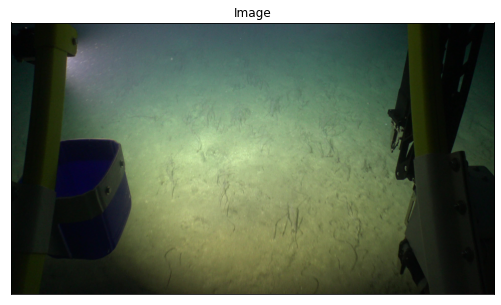

In [6]:
# Show an image from the training test
temp_dataset = Dataset(test_dir)

image, label = temp_dataset[2]
print(label)
visualize(
    image=image, 
)

Inicialización del dataloader

In [7]:
test_dataset = Dataset(test_dir)
test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

Definición de la capa para recortar el tercio central de la imagen

In [8]:
class Crop(tf.keras.layers.Layer):
    def __init__(self, name=None, trainable=None, dtype=None):
        super(Crop, self).__init__()
        width_proportion = 0.67
        self.p = tf.constant(width_proportion, dtype=tf.float32)

    def call(self, inputs):
        shape = tf.shape(inputs)
        
        i_shape = shape[-2]
        i_shape_f = tf.cast(i_shape, dtype=tf.float32)
        ran = tf.cast(tf.round((i_shape_f * self.p) / 2), dtype=tf.int32)
        low = i_shape // 2 - ran
        hight = i_shape // 2 + ran
        
        return inputs[:, :, low:hight, :]

Carga del modelo

In [9]:
model = keras.models.load_model(best_model_ckpt, custom_objects={'Crop': Crop})

#### Test

In [10]:
model.evaluate(test_dataloader)

498/498 [==============================] - 39s 70ms/step - loss: 0.1024 - categorical_accuracy: 0.9719 - accuracy: 0.9719


[0.10235736519098282, 0.9718875288963318, 0.9718875288963318]